# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## October 2021

<br>

Competition Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goal: Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. 

Inference Problem:  Given known variables about a house, accurately predict its sale price.

Deliverable: Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Import modules

In [233]:
# from tensorflow import keras
# from tensorflow.keras.layers import Dense, Activation

In [234]:
import os 

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.formula.api import glm 

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

Load in the data

In [235]:
# optional directory set-up
train = pd.read_csv("../../housing_data/train.csv")
test = pd.read_csv("../../housing_data/test.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")

In [236]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (1460, 81)
test shape: (1459, 80)


Base functions for standard data cleanining to use in all models

In [237]:
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df



# Function for some standard feature engineering to use in all models
def standard_feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    # simplifying more vars
    # electrical:
    df['Electrical'] = df['Electrical'].map(lambda x: "SBrkr" if x == "SBrkr" else "Fuse")
    # exterior:
    df['Exterior'] = df['Exterior1st'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Expensive" if (x in ("VinylSd", "CemntBd", "Stone", "ImStucc")) else(
        "Cheap" if (x in ("BrkComm", "AsphShn", "CBlock", "AsbShng")) else(
        "Moderate")))
    df = df.drop(columns=['Exterior1st', 'Exterior2nd'])
    # garage
    df['GarageQual'] = df['GarageQual'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Good" if (x in ("Ex", "Gd")) else(
        "Medium" if (x in ("TA")) else(
        "Bad")))
    df['Heating'] = df['Heating'].map(lambda x: "Gas" if x in ("GasA", "GasW") else "Other")

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        # not much variation:
        "LowQualFinSF", 
        "LandSlope", 
        "MiscVal", 
        "RoofMatl",
        "Condition2",
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        "PoolArea", # binarized above
        "Utilities", # only 1 obs in training data different from regular
        "HouseStyle" # already explained in other vars
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # expensive neighborhoods
    top_10_neighborhoods = ['NoRidge', 'NridgHt', 'StoneBr','Timber','Veenker','Somerst','ClearCr','Crawfor','CollgCr','Blmngtn']
    df['Expensive_neighborhood'] = df['Neighborhood'].map(lambda x: 1 if x in top_10_neighborhoods else 0)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df

In [238]:
# shape after standard manipulations
print(standard_feature_eng(na_clean(train)).shape)

(1460, 69)


# Modeling

## OLS

Function to prep data for a very baseline linear model

In [239]:
def lm_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
              'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms']

    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)
    
    return df

Train OLS model

In [240]:
# data setups
X_train = lm_df_clean(train)
X_test = lm_df_clean(test, test_data=True)
Y_train = np.log(train.SalePrice)
Y_test = np.log(sample.SalePrice)

# fit to train data
lr_1 = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

Evaluate performance

In [241]:
print("Fit on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))

yhat_train = lr_1.predict(X_train)
yhat_test = lr_1.predict(X_test)

# rmse
rmse_train = (np.mean((yhat_train - Y_train)**2))**.5
rmse_test = (np.mean((yhat_test - Y_test)**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))


Fit on training data: 0.869
Fit on testing data: -16.079
Log RMSE on training data: 0.144
Log RMSE on testing data: 0.372


Graph of responses vs actuals

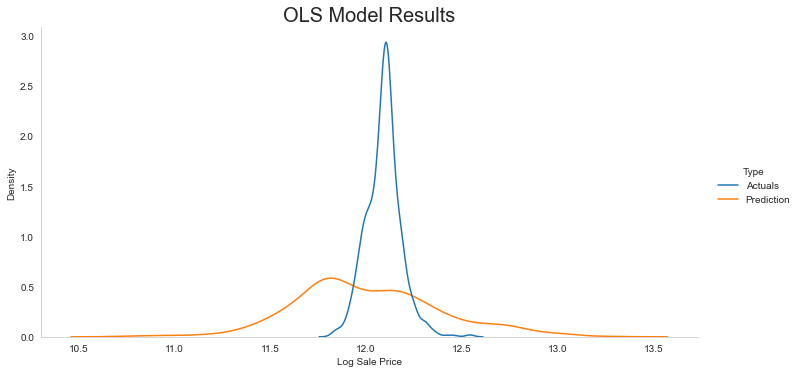

In [242]:
def dist_plot(actuals, preds, title):
    ols_resuls_df = pd.DataFrame({
        "Actuals": actuals, 
        "Prediction": preds
    }).melt(var_name="Type", value_name="log_sale_price")

    sns.set_style("whitegrid", rc = {'axes.grid' : False})
    sns.displot(ols_resuls_df, x="log_sale_price", hue="Type", kind="kde", aspect=2)\
        .set_axis_labels(x_var="Log Sale Price")

    plt.title(title,fontdict={"fontsize": 20})
    print("")

dist_plot(actuals=Y_test, preds=yhat_test, title="OLS Model Results")

## OLS with 1 variable

An OLS with 1 variable, overall quality, outperforms the more complex OLS model with many features. This uses the variable with highest coefficient from initial correlation matrix.

In [243]:
# data setup function
def lm_overall_quality_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)
    df = df.loc[:, ['OverallQual']]
    
    return df

In [244]:
# data setups
X_train = lm_overall_quality_df_clean(train)
X_test = lm_overall_quality_df_clean(test, test_data=True)
Y_train = np.log(train.SalePrice)
Y_test = np.log(sample.SalePrice)

# fit to train data
lr_overall_quality = LinearRegression(fit_intercept=True).fit(X_train, Y_train)

In [245]:
# Evaluate performance
print("Fit on training data: {:.3f}".format(lr_overall_quality.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_overall_quality.score(X_test ,Y_test)))

yhat_train = lr_overall_quality.predict(X_train)
yhat_test = lr_overall_quality.predict(X_test)

# set negative values to 0.1
#yhat_train = np.array([0.1 if i < 0 else i for i in yhat_train])
#yhat_test = [0.1 if i < 0 else i for i in yhat_test]

# rmse
rmse_train = (np.mean((yhat_train - Y_train)**2))**.5
rmse_test = (np.mean((yhat_test - Y_test)**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))


Fit on training data: 0.668
Fit on testing data: -14.120
Log RMSE on training data: 0.230
Log RMSE on testing data: 0.350


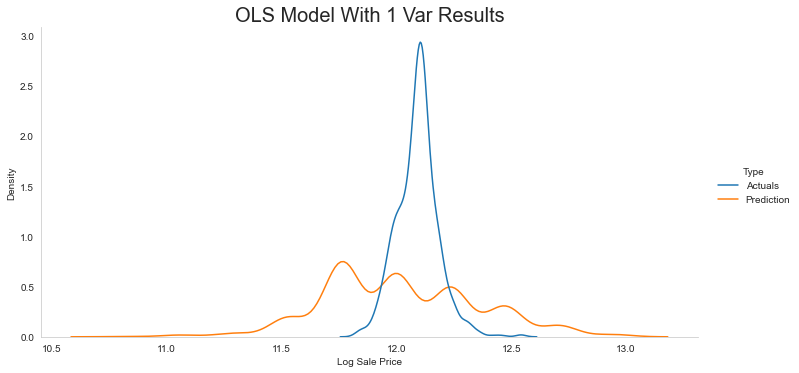

In [246]:
dist_plot(actuals=Y_test, preds=yhat_test, title="OLS Model With 1 Var Results")

## Lasso model v1

In [247]:
# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    #df = standard_feature_eng(df, test_data = test_data)

    # log transformations
    df["GrLivArea"] = np.log(df["GrLivArea"])

    # select only vars needed
    if test_data:
        df = df[["GrLivArea","OverallQual"]] 
    else:
        df["SalePrice"] = np.log(df["SalePrice"])
        df = df[["GrLivArea","OverallQual", "SalePrice"]]
    
    return df

In [248]:
# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
Y_test = np.log(sample.SalePrice)

# fit to train data
lasso_fit_v1 = Lasso(alpha=.01).fit(X_train[["GrLivArea","OverallQual"]], Y_train)

In [249]:
# Evaluate performance
yhat_train = lasso_fit_v1.predict(X_train[["GrLivArea","OverallQual"]])
yhat_test = lasso_fit_v1.predict(X_test[["GrLivArea","OverallQual"]])

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("RMSE on training data: {:.3f}".format(rmse_train))
print("RMSE on testing data: {:.3f}".format(rmse_test))

RMSE on training data: 0.202
RMSE on testing data: 0.332


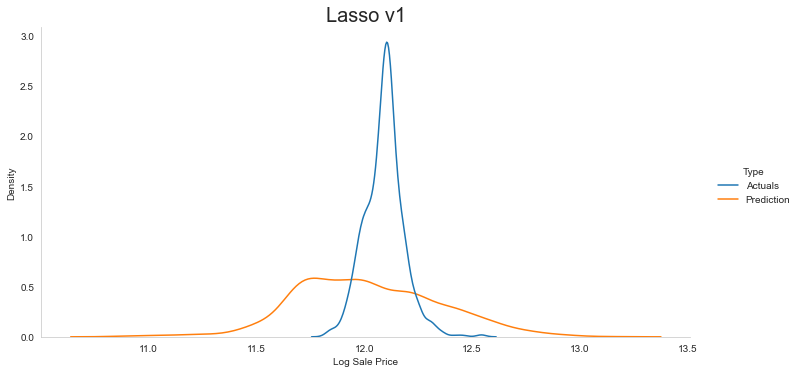

In [250]:
dist_plot(actuals=Y_test, preds=yhat_test, title="Lasso v1")

## Lasso model v2

I think i used the wrong lasso model above. Using this one instead

In [251]:
# first build one hot encoder based on the training data
train_lasso = standard_feature_eng(na_clean(train))
enc_lasso = OneHotEncoder(handle_unknown = 'ignore')
enc_lasso.fit(train_lasso.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_lasso.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# data setup function
def lasso_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_lasso.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)

    # log transformations
    #df["GrLivArea"] = np.log(df["GrLivArea"])
    
    # select only vars needed
    if test_data:
        df = df.drop(columns=["Id"])
    else:
        df = df.drop(columns=["Id"])
        df['SalePrice'] = np.log(df['SalePrice'])
        #df = df[["GrLivArea","OverallQual", "SalePrice"]]
    
    return df

In [252]:
# data setups
X_train = lasso_df_clean(train)
X_test = lasso_df_clean(test, test_data=True)
Y_train = X_train.SalePrice
Y_test = np.log(sample.SalePrice)

# fit to train data
lasso_fit = Lasso(alpha=.01).fit(X_train.drop(columns=['LogSalePrice', 'SalePrice']), Y_train)

In [253]:
# Evaluate performance
yhat_train = lasso_fit.predict(X_train.drop(columns=['LogSalePrice', 'SalePrice']))
yhat_test = lasso_fit.predict(X_test)

# rmse
rmse_train = (np.mean((yhat_train - np.log(train.SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("RMSE on training data: {:.3f}".format(rmse_train))
print("RMSE on testing data: {:.3f}".format(rmse_test))

RMSE on training data: 0.152
RMSE on testing data: 0.358


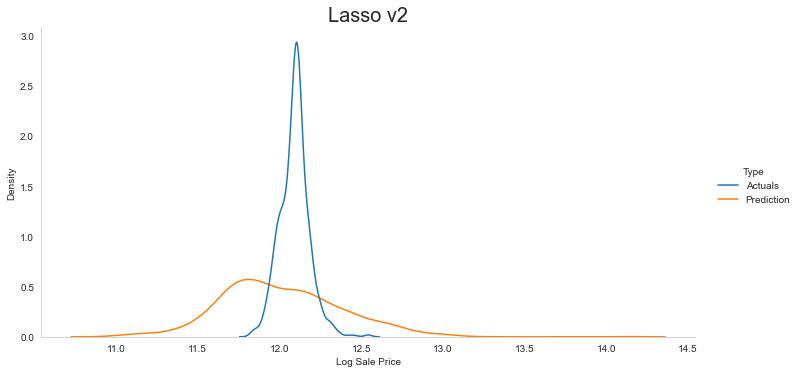

In [254]:
dist_plot(actuals=np.log(sample.SalePrice), preds=yhat_test, title="Lasso v2")

## Random forest with cross validation

In [255]:
# first build one hot encoder based on the training data
train_rf = standard_feature_eng(na_clean(train))
enc_rf = OneHotEncoder(handle_unknown = 'ignore')
enc_rf.fit(train_rf.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_rf.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

In [256]:
# Random forest data clean function
def rf_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_rf.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO FEATURE ENGINEERING HERE
    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df

Running this cross validation grid search took almost 30 minutes on my computer. I commented the results at the bottom so we don't have to keep re-running.

In [257]:
# preprocess the data
df_rf = rf_df_clean(train)

# create the train and test splits
dev_train, dev_test = train_test_split(df_rf, test_size=0.1, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto', random_state=1)

# run grid search on range of values
grid = {
    "n_estimators": np.arange(100, 1001, 100),
    'max_depth': np.arange(10, 101, 5),
    'min_samples_split': [2, 5, 7],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 3)

# run the search:
# this took 26 min to run. 
# re-run if you want
#results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice']), dev_train.LogSalePrice)

# check out the best parameters
# print(results.best_params_)
# {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 900}

In [258]:
# finally, run model on best parameters and train on full dataset
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    random_state=1
    )

# fit the model
df_rf = rf_df_clean(train)
rf_reg.fit(df_rf.drop(columns = ["SalePrice", 'LogSalePrice']), df_rf.LogSalePrice)

# evaluate performance
yhat_rf = rf_reg.predict(rf_df_clean(test, test_data=True))
resids = yhat_rf - np.log(sample.SalePrice)
rmse_rf = np.mean(resids**2)**.5
print("RF Log RMSE: {:.4f}".format(rmse_rf))

RF Log RMSE: 0.3643


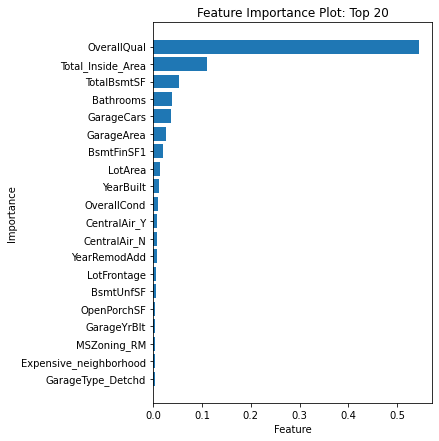

In [259]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': dev_train.drop(columns = ["SalePrice", 'LogSalePrice']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

sns.reset_orig()
fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")

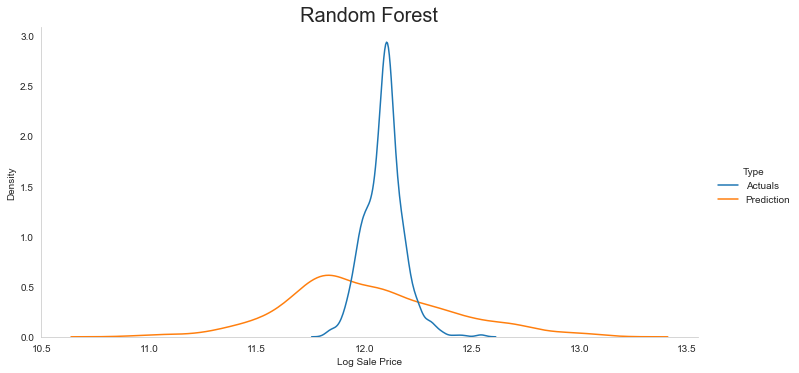

In [260]:
dist_plot(actuals=np.log(sample.SalePrice), preds=rf_reg.predict(rf_df_clean(test, test_data=True)), title="Random Forest")

## Random Forest, but split up dataset

In [261]:
# first build one hot encoder based on the training data
train_rf = standard_feature_eng(na_clean(train)).drop(columns="Neighborhood")
enc_rf = OneHotEncoder(handle_unknown = 'ignore')
enc_rf.fit(train_rf.select_dtypes(include=["object"]))
one_hot_columns = pd.get_dummies(train_rf.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# Random forest data clean function
def rf_df_clean_high_low(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # drop neighborhood var
    df = df.drop(columns="Neighborhood")
    
    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_rf.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO FEATURE ENGINEERING HERE

    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df

In [262]:
# split data into high and low value neighborhoods
train_high = rf_df_clean_high_low(train)
train_high = train_high.loc[train_high.Expensive_neighborhood == 1]

train_low = rf_df_clean_high_low(train)
train_low = train_low.loc[train_low.Expensive_neighborhood == 0]

# split up the test data too just like i will in the model
test_high = rf_df_clean_high_low(test, test_data=True)
test_high_y = np.log(sample.loc[test_high.Expensive_neighborhood == 1]['SalePrice'])
test_high = test_high.loc[test_high.Expensive_neighborhood == 1]

test_low = rf_df_clean_high_low(test, test_data=True)
test_low_y = np.log(sample.loc[test_low.Expensive_neighborhood == 0]['SalePrice'])
test_low = test_low.loc[test_low.Expensive_neighborhood == 0]

Start w/ the high cost ones

In [263]:
# create the train and test splits
dev_train, dev_test = train_test_split(train_high, test_size=0.01, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto', random_state=1)

# run grid search on range of values
grid = {
    "n_estimators": [350, 400, 450],
    'max_depth': [15, 17, 19, 20],
    #'min_samples_split': [2, 10, 20],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 7)

# run the search:
# results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice']), dev_train.LogSalePrice)

# check out the best parameters
# (I ran this several times)
# print(results.best_params_)
# {'max_depth': 15, 'n_estimators': 400, 'min_samples_split': 2}
# {'max_depth': 17, 'n_estimators': 400}

In [264]:
# now fit model w/ optimal hyperparams
# finally, run model on best parameters and train on full dataset
rf_reg_high = RandomForestRegressor(
    n_estimators = 400,
    max_depth = 17,
    max_features = 'auto',
    bootstrap = True, 
    random_state=1
    )

# fit the model
rf_reg_high.fit(train_high.drop(columns = ["SalePrice", 'LogSalePrice']), train_high.LogSalePrice)

# evaluate performance
yhat_rf = rf_reg_high.predict(test_high)
resids = yhat_rf - test_high_y
rmse_rf = np.mean(resids**2)**.5
print("RF Log RMSE on Expensive Homes: {:.4f}".format(rmse_rf))

RF Log RMSE on Expensive Homes: 0.3978


Now for the low cost ones

In [265]:
# create the train and test splits
#dev_train, dev_test = train_test_split(train_low, test_size=0.01, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto', random_state=1)

# run grid search on range of values
grid = {
    "n_estimators": [500, 550],
    'max_depth': [20, 22, 25, 30],
    #'min_samples_split': [2, 10, 20],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 5)

# run the search:
# results = gscv.fit(train_low.drop(columns = ["SalePrice", 'LogSalePrice']), train_low.LogSalePrice)

# check out the best parameters
# (I ran this several times)
# print(results.best_params_)
# {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
# {'max_depth': 22, 'n_estimators': 500}

In [266]:
# now fit model w/ optimal hyperparams
# finally, run model on best parameters and train on full dataset
rf_reg_low = RandomForestRegressor(
    n_estimators = 500,
    max_depth = 22,
    max_features = 'auto',
    bootstrap = True, 
    random_state=1
    )

# fit the model
rf_reg_low.fit(train_low.drop(columns = ["SalePrice", 'LogSalePrice']), train_low.LogSalePrice)

# evaluate performance
yhat_rf = rf_reg_low.predict(test_low)
resids = yhat_rf - test_low_y
rmse_rf = np.mean(resids**2)**.5
print("RF Log RMSE on Cheap Homes: {:.4f}".format(rmse_rf))

RF Log RMSE on Cheap Homes: 0.3534


Combine the two models

In [306]:
def rf_high_low(df):

    # create id to put df back into same exact order
    df['Id'] = list(range(0, df.shape[0]))

    # split dataset into high low
    df_high = df.loc[df.Expensive_neighborhood == 1]
    df_low = df.loc[df.Expensive_neighborhood == 0]

    # run rf on high/low
    df_high = df_high.assign(yhat = rf_reg_high.predict(df_high.drop(columns="Id")))
    df_low = df_low.assign(yhat = rf_reg_low.predict(df_low.drop(columns="Id")))

    # combine, sort values, and return results
    df_preds = pd.concat([df_high[['Id', 'yhat']], df_low[['Id', 'yhat']]], axis=0)
    df_preds = df_preds.sort_values("Id", ascending=True)
    return np.array(df_preds.yhat)    

In [308]:
# evaluate performance
yhat_rf = rf_high_low(rf_df_clean_high_low(test, test_data=True))
resids = yhat_rf - np.log(sample.SalePrice)
rmse_rf = np.mean(resids**2)**.5
print("RF Log RMSE Splitting up homes: {:.4f}".format(rmse_rf))

RF Log RMSE Splitting up homes: 0.3687


## Gradient boosting regression

Data set ups

In [27]:
# first build one hot encoder based on the training data
train_xgb = standard_feature_eng(na_clean(train))
enc_xgb = OneHotEncoder(handle_unknown = 'ignore')
enc_xgb.fit(train_xgb.select_dtypes(include=["object"]))
one_hot_columns_xgb = pd.get_dummies(train_xgb.select_dtypes(include=["object"])).columns
# will use this encoder in the function below

# xgboost data clean function
def xgb_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # one hot encode using encoder above
    categorical_cols = pd.DataFrame(enc_xgb.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_columns_xgb
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1)
    
    # DO MORE FEATURE ENGINEERING HERE LATER
    df = df.drop(columns = ['Id'])
    
    return df


# preprocess the data
df_xgb = xgb_df_clean(train)

# get X feature names
xgb_cols = np.array(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']).columns)

# create the train and test splits
dev_train_X, dev_test_X, dev_train_y, dev_test_y = train_test_split(
    df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), 
    np.log(df_xgb['SalePrice']), 
    test_size=0.1, random_state=1)

# convert data to DMatrix format
dmat_train = xgb.DMatrix(dev_train_X, dev_train_y, feature_names=xgb_cols)
dmat_test = xgb.DMatrix(dev_test_X, dev_test_y, feature_names=xgb_cols)

Cross validate to find optimal hyperparameters

In [28]:
# sklearn api for cross validating
xgb_reg_cv = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    # subsample=.7, 
    # colsample_bytree=.7
)

# set up grid for hyperparam tuning
cv_grid = {
    "n_estimators": [500, 600], 
    "max_depth": [6, 10, 20, 30],
    "learning_rate": [.05, .1, .15], 
    'reg_alpha': [0, .1], 
    'reg_lambda': [0, .1], 
}

# more randomization option
gscv = GridSearchCV(estimator=xgb_reg_cv, param_grid=cv_grid, n_jobs=-1, cv=3)

# fit step
# (11 minutes)
# xgb_cv_results = gscv.fit(dev_train_X, dev_train_y)
# print(xgb_cv_results.best_params_)
# {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

Hyper parameter tune a bit further

In [29]:
# sklearn api for cross validating
xgb_reg_cv2 = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    n_estimators=500
)

# set up grid for hyperparam tuning
cv_grid = {
    "max_depth": [5, 6, 7],
    "learning_rate": [.07, .1], 
    'reg_alpha': [.1, .2, .3, 1], 
    'reg_lambda': [.1, .2, .3, 1], 
}

# set up the grid search
gscv = GridSearchCV(estimator=xgb_reg_cv2, param_grid=cv_grid, n_jobs=-1, cv=3)

# fit step
# (7 minutes)
# xgb_cv_results_v2 = gscv.fit(dev_train_X, dev_train_y)
# print(xgb_cv_results_v2.best_params_)
# {'learning_rate': 0.07, 'max_depth': 5, 'reg_alpha': 0.2, 'reg_lambda': 0.3}

Run xgboost again using the optimal hyper parameters from above

In [30]:
# specify final params
xgb_reg = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    learning_rate=.07,
    max_depth=5,
    n_estimators=500, 
    reg_alpha=.2, 
    reg_lambda=.3
)

# fit to train
xgb_reg.fit(df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), np.log(df_xgb['SalePrice']))

# evaluate performance on test
yhat = xgb_reg.predict(xgb_df_clean(test, test_data=True))
resids = yhat - np.log(sample.SalePrice)
print("Log RMSE: {:.4f}".format(np.mean(resids**2)**.5))

Log RMSE: 0.3900


In [31]:
# trying the xgboost implementation just to compare with the sklearn api
# create the train and test splits
dev_train_X, dev_test_X, dev_train_y, dev_test_y = train_test_split(
    df_xgb.drop(columns = ["SalePrice", 'LogSalePrice']), 
    np.log(df_xgb['SalePrice']), 
    test_size=0.1, random_state=1)

# convert data to DMatrix format
dmat_train = xgb.DMatrix(dev_train_X, dev_train_y, feature_names=xgb_cols)
dmat_test = xgb.DMatrix(dev_test_X, dev_test_y, feature_names=xgb_cols)

# final fit
booster_xgb = xgb.train({

    "booster": "gbtree", 
    "n_estimators": 500,
    "eta": .07, 
    "max_depth": 5, 
    "lambda": .3, 
    "alpha": .2, 
    "eval_metric": "rmse", 
    "objective": "reg:squarederror"
    },

    dmat_train,
    num_boost_round=20,
    evals=[(dmat_train, "train"), (dmat_test, "test")]
)

# evaluate final performance on test
df_xgb_test = xgb.DMatrix(xgb_df_clean(test, test_data=True))
preds = booster_xgb.predict(df_xgb_test)
redids = preds - np.log(sample.SalePrice)
print("Log RMSE: {:.4f}".format(np.mean(resids**2)**.5))

[0]	train-rmse:10.72639	test-rmse:10.70904
[1]	train-rmse:9.97648	test-rmse:9.95969
[2]	train-rmse:9.27908	test-rmse:9.26282
[3]	train-rmse:8.63051	test-rmse:8.61476
[4]	train-rmse:8.02736	test-rmse:8.01209
[5]	train-rmse:7.46644	test-rmse:7.45205
[6]	train-rmse:6.94476	test-rmse:6.93240
[7]	train-rmse:6.45959	test-rmse:6.44802
[8]	train-rmse:6.00844	test-rmse:5.99731
[9]	train-rmse:5.58888	test-rmse:5.57864
[10]	train-rmse:5.19864	test-rmse:5.18913
[11]	train-rmse:4.83574	test-rmse:4.82653
[12]	train-rmse:4.49827	test-rmse:4.48988
[13]	train-rmse:4.18442	test-rmse:4.17753
[14]	train-rmse:3.89258	test-rmse:3.88587
[15]	train-rmse:3.62115	test-rmse:3.61544
[16]	train-rmse:3.36873	test-rmse:3.36332
[17]	train-rmse:3.13400	test-rmse:3.12906
[18]	train-rmse:2.91574	test-rmse:2.91185
[19]	train-rmse:2.71275	test-rmse:2.70950
Log RMSE: 0.3900


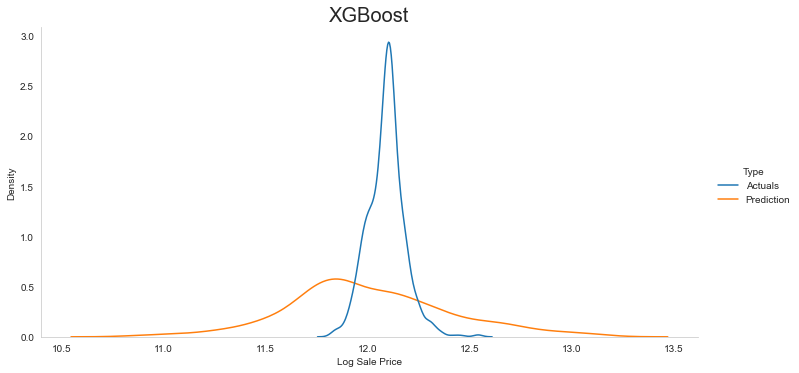

In [32]:
dist_plot(actuals=np.log(sample.SalePrice), preds=xgb_reg.predict(xgb_df_clean(test, test_data=True)), title="XGBoost")

In [33]:
# a more overfit xgbooster
booster_deep_trees = xgb.train({

    "booster": "gbtree", 
    "max_depth": 30, 
    "eta": .4, 
    "gamma": .01, 
    "subsample": 0.6,
    "lambda": .7, 
    "alpha": 0, 
    "max_bin": 256, 
    "colsample_bytree": .7, # proportion of features
    "eval_metric": "rmse", 
    "objective": "reg:squarederror"
    },

    dmat_train,
    evals=[(dmat_train, "train"), (dmat_test, "test")] 
)

# evaluate final performance on test
df_xgb_test = xgb.DMatrix(xgb_df_clean(test, test_data=True))
preds = booster_deep_trees.predict(df_xgb_test)
redids = preds - np.log(sample.SalePrice)
print("Log RMSE: {:.4f}".format(np.mean(resids**2)**.5))

[0]	train-rmse:6.93054	test-rmse:6.91349
[1]	train-rmse:4.16779	test-rmse:4.15462
[2]	train-rmse:2.51219	test-rmse:2.51154
[3]	train-rmse:1.52525	test-rmse:1.53274
[4]	train-rmse:0.92692	test-rmse:0.93953
[5]	train-rmse:0.57653	test-rmse:0.59127
[6]	train-rmse:0.36835	test-rmse:0.40155
[7]	train-rmse:0.24324	test-rmse:0.28134
[8]	train-rmse:0.16883	test-rmse:0.21632
[9]	train-rmse:0.12502	test-rmse:0.19177
Log RMSE: 0.3900


# Neural Net

In [34]:
# Neural net data clean function
def nn_df_clean_pt1(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # feature engineer
    Expensive_neighborhoods = ['Somerst', 'Blmngtn', 'BrDale', 'NridgHt', 'StoneBr', 'MeadowV']
    df['Expensive_neighborhood'] = df['Neighborhood'].apply(lambda x: any([k in x for k in Expensive_neighborhoods]))

    # select smaller subset of features for NN
    df = df[['LotArea', 'OverallQual','Remodeled', 'Total_Inside_Area', 'Bathrooms', 'Expensive_neighborhood']]
    
    return df


# set up standard scaler based on train
sc = StandardScaler().fit(nn_df_clean_pt1(train))

# now build reproducible NN data clean function
def nn_df_clean(df, test_data = False):

    # first run standard data cleaning steps
    df = na_clean(df)
    df = standard_feature_eng(df, test_data = test_data)

    # feature engineer
    Expensive_neighborhoods = ['Somerst', 'Blmngtn', 'BrDale', 'NridgHt', 'StoneBr', 'MeadowV']
    df['Expensive_neighborhood'] = df['Neighborhood'].apply(lambda x: any([k in x for k in Expensive_neighborhoods]))

    # select smaller subset of features for NN
    df = df[['LotArea', 'OverallQual','Remodeled', 'Total_Inside_Area', 'Bathrooms', 'Expensive_neighborhood']]

    # standard scaler
    df = sc.transform(df)
    
    return df

In [36]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(nn_df_clean(train), np.log(train.SalePrice), random_state=3, test_size=.1)

In [7]:
from tensorflow.keras.layers import Dense, Activation

In [2]:
# having 6 neuron is based on the number of available features
# for some reason I had to import these keras packages separately first, otherwise my other ones wouldn't load correctly 
from keras.layers import Dense, Activation

model = keras.models.Sequential()
from keras.layers  as Dense

model.add(Dense(6,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(1))

# Compiling the ANN
model.compile(optimizer='Adam',loss='mean_squared_error')

# fit to training data
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)

# model.summary()
# loss_df = pd.DataFrame(model.history.history)
# loss_df.plot(figsize=(12,8))

# evaluate performance on test
yhat_nn = model.predict(nn_df_clean(test, test_data=True))
print(yhat_nn)

In [1]:
# evaluate performance on test
print("hi")

hi


0    1
1    2
dtype: int64

1

# Final Ensemble model

This doesn't work yet, but this is how I have in mind to make the final predictions. Make sure each of these models are pretrained from above:
- OLS (lr_1)
- OLS Simple (lr_overall_quality)
- GLM (still want this??)
- Lasso (update)
- Random forest (rf_reg)
- Extreme gradient boosting machine (update)


Then we can pass in brand new incoming data to make predictions with this function

In [382]:
# Load in brand new data to make sure it all works
working_dir = !pwd
train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

In [393]:
def housing_ensemble_model(df, output_type='regular'):
    '''This is the final model that takes in raw data, and makes predictions'''

    # OLS
    yhat_ols1 = lr_1.predict(lm_df_clean(df, test_data=True))

    # OLS Simple
    yhat_ols_simple = lr_overall_quality.predict(lm_overall_quality_df_clean(df, test_data=True))

    # GLM

    # Lasso
    yhat_lasso = lasso_fit.predict(lasso_df_clean(df, test_data=True))

    # Random forest
    yhat_rf = rf_reg.predict(rf_df_clean(df, test_data=True))

    # XGB
    yhat_xgb = xgb_reg.predict(xgb_df_clean(df, test_data=True))

    # make ensemble prediction
    # Do more work to come up w/ weights. This is just a sample
    yhat_final = yhat_ols1*(1/5) + yhat_ols_simple * (1/5) + yhat_lasso * (1/5) + yhat_rf * (1/5) + yhat_xgb * (1/5)

    if output_type == "not logged":
        return np.exp(yhat_final)

    elif output_type == "df":
        result_df = pd.DataFrame({
            "ols1":          yhat_ols1, 
            "ols_simple":    yhat_ols_simple, 
            "lasso":         yhat_lasso, 
            "random_forest": yhat_rf, 
            "xgb":           yhat_xgb, 
            "ensemble":      yhat_final
        })
        return result_df

    elif output_type == "test performances":
        result_df = {
            "ols1":          np.mean((np.log(sample.SalePrice) - yhat_ols1)**2)**.5,
            "ols_simple":    np.mean((np.log(sample.SalePrice) - yhat_ols_simple)**2)**.5,
            "lasso":         np.mean((np.log(sample.SalePrice) - yhat_lasso)**2)**.5,
            "random_forest": np.mean((np.log(sample.SalePrice) - yhat_rf)**2)**.5, 
            "xgb":           np.mean((np.log(sample.SalePrice) - yhat_xgb)**2)**.5, 
            "ensemble":      np.mean((np.log(sample.SalePrice) - yhat_final)**2)**.5
        }
        return result_df

    else:
        return yhat_final


In [389]:
# final ensemble model RMSE
yhat_train = housing_ensemble_model(train.drop(columns = ["SalePrice"]))
yhat_test = housing_ensemble_model(test)

rmse_train = np.mean((train.SalePrice - np.exp(yhat_train))**2)**.5
rmse_test = np.mean((sample.SalePrice - np.exp(yhat_test))**2)**.5

# evaluate rmse  on the testing data
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

# log results
rmse_train_log = np.mean((np.log(train.SalePrice) - yhat_train)**2)**.5
rmse_test_log = np.mean((np.log(sample.SalePrice) - yhat_test)**2)**.5
# evaluate rmse  on the testing data
print("\nLog RMSE Train: {}".format(rmse_train_log))
print("Log RMSE Test: {}".format(rmse_test_log))


RMSE Train: 22297.8940020255
RMSE Test: 66875.2648708175

Log RMSE Train: 0.10453871022070585
Log RMSE Test: 0.355971143969446


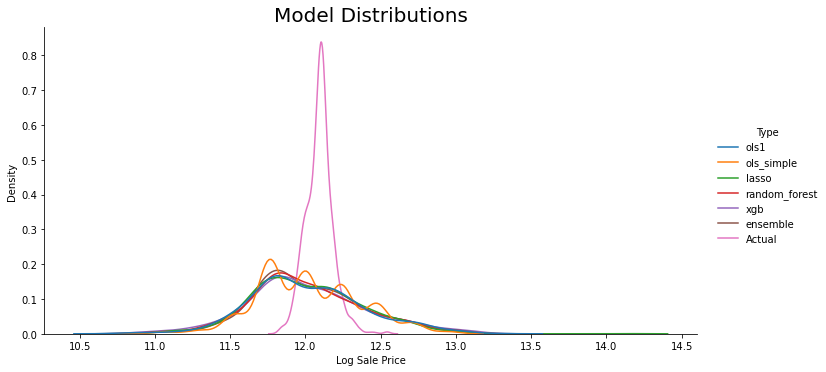

In [395]:
# see distribution of the accuracies
result_df = housing_ensemble_model(test, output_type="df")
result_df = pd.concat([result_df, 
    pd.DataFrame({"Actual": np.log(sample.SalePrice)})
    ], axis=1)

result_df = result_df.melt(var_name="Type", value_name="log_sale_price")
result_df

sns.reset_orig()
sns.displot(result_df, x="log_sale_price", hue="Type", kind="kde", aspect=2).set_axis_labels(x_var="Log Sale Price")
plt.title("Model Distributions",fontdict={"fontsize": 20})
print("")

See each model's performance


In [394]:
housing_ensemble_model(test, output_type="test performances")

{'ols1': 0.37203063827417354,
 'ols_simple': 0.3500410739830086,
 'lasso': 0.35722015970506366,
 'random_forest': 0.36451359157240215,
 'xgb': 0.38995480858748494,
 'ensemble': 0.355971143969446}

# Scratch work below for sample submissions

In [320]:
lasso_data = lasso_df_clean(test, test_data=True)
yhat_lasso = lasso_fit.predict(lasso_data)

In [323]:
sample_submission = pd.DataFrame({
    "Id": test.Id,
    "SalePrice": np.exp(yhat_lasso)
})
sample_submission.to_csv("~/Desktop/sample_submission_lasso.csv", index=False)